鉴于我自己的特征工程没有收到很好的效果，所以我参考了[这篇](https://www.kaggle.com/laurenstc/top-2-of-leaderboard-advanced-fe)的方法。然后在此基础上（包括ridge和xgboost），再结合自己的预测项目（包括随机森林，GBRT，深度学），来组合一个最好的预测结果。

读取数据：

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
train = pd.read_csv("./Data/kaggle_house_train.csv")
test = pd.read_csv("./Data/kaggle_house_test.csv")

In [2]:
print("Train set size:", train.shape)
print("Test set size:", test.shape)

Train set size: (1460, 81)
Test set size: (1459, 80)


## 1 数据的预处理

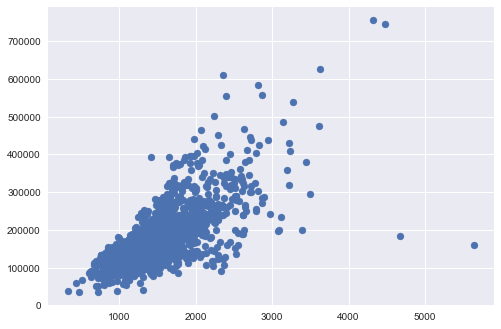

In [3]:
plt.scatter(train.GrLivArea, train.SalePrice)

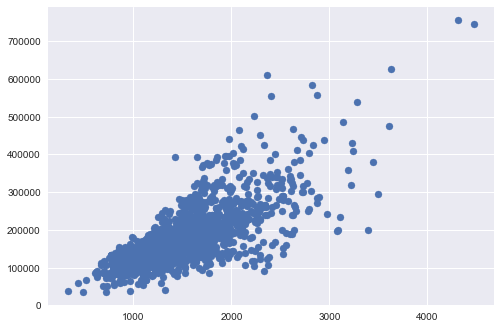

In [4]:
train = train[train.GrLivArea < 4500]
plt.scatter(train.GrLivArea, train.SalePrice)

In [5]:
import numpy as np
print(len(np.unique(train['Id'])) == len(train))
len(np.unique(test['Id'])) == len(test)

True


True

In [6]:
len(train)

1458

In [7]:
train = train.drop(['Id'], axis=1)
test = test.drop(['Id'], axis=1)

In [8]:
print("Train set size:", train.shape)
print("Test set size:", test.shape)

Train set size: (1458, 80)
Test set size: (1459, 79)


In [9]:
df = pd.concat([train.SalePrice, np.log(train.SalePrice + 1).rename('LogSalePrice')], axis=1, names=['SalePrice', 'LogSalePrice'])
df.head()

,SalePrice,LogSalePrice
0,208500,12.247699
1,181500,12.109016
2,223500,12.317171
3,140000,11.849405
4,250000,12.429220


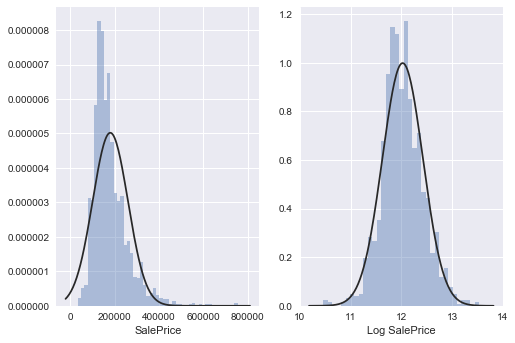

In [10]:
from scipy.stats import norm, skew

plt.subplot(1, 2, 1)
sns.distplot(train.SalePrice, kde=False, fit = norm)

plt.subplot(1, 2, 2)
sns.distplot(np.log(train.SalePrice + 1), kde=False, fit = norm)
plt.xlabel('Log SalePrice')

## 2 特征工程

In [11]:
y = train.SalePrice.reset_index(drop=True) #w我们需要时刻关注index的状况
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

In [12]:
print(train_features.shape)
print(test_features.shape)

(1458, 79)
(1459, 79)


In [13]:
features = pd.concat([train_features, test_features]).reset_index(drop=True)#again when concat,remmeber reset_index
features.shape

(2917, 79)

### 缺失值处理：

In [14]:
nulls = np.sum(features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

                 0        1
PoolQC        2908   object
MiscFeature   2812   object
Alley         2719   object
Fence         2346   object
FireplaceQu   1420   object
LotFrontage    486  float64
GarageFinish   159   object
GarageQual     159   object
GarageCond     159   object
GarageYrBlt    159  float64
GarageType     157   object
BsmtExposure    82   object
BsmtCond        82   object
BsmtQual        81   object
BsmtFinType2    80   object
BsmtFinType1    79   object
MasVnrType      24   object
MasVnrArea      23  float64
MSZoning         4   object
BsmtFullBath     2  float64
BsmtHalfBath     2  float64
Functional       2   object
Utilities        2   object
GarageArea       1  float64
GarageCars       1  float64
Electrical       1   object
KitchenQual      1   object
TotalBsmtSF      1  float64
BsmtUnfSF        1  float64
BsmtFinSF2       1  float64
BsmtFinSF1       1  float64
Exterior2nd      1   object
Exterior1st      1   object
SaleType         1   object
There are 34 columns

In [15]:
features['Functional'] = features['Functional'].fillna('Typ')
features['Electrical'] = features['Electrical'].fillna("SBrkr")
features['KitchenQual'] = features['KitchenQual'].fillna("TA")

features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])

features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

In [16]:
pd.set_option('max_columns', None) #pandas 的set_option可以改变最大显示列
features[features['PoolArea'] > 0 & features['PoolQC'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
197,75,RL,174.0,25419,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Artery,Norm,1Fam,2Story,8,4,1918,1990,Gable,CompShg,Stucco,Stucco,None,0.0,Gd,Gd,PConc,TA,TA,No,GLQ,1036.0,LwQ,184.0,140.0,1360.0,GasA,Gd,Y,SBrkr,1360,1360,392,3112,1.0,1.0,2,0,4,1,Gd,8,Typ,1,Ex,Detchd,1918.0,Unf,2.0,795.0,TA,TA,Y,0,16,552,0,0,512,Ex,GdPrv,NaN,0,3,2006,WD,Abnorml
809,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1974,1999,Hip,CompShg,HdBoard,HdBoard,BrkFace,99.0,TA,TA,CBlock,TA,TA,No,ALQ,663.0,LwQ,377.0,0.0,1040.0,GasA,Fa,Y,SBrkr,1309,0,0,1309,1.0,0.0,1,1,3,1,Gd,5,Typ,1,Fa,Attchd,1974.0,RFn,2.0,484.0,TA,TA,Y,265,0,0,0,0,648,Fa,GdPrv,NaN,0,1,2006,WD,Normal
1169,80,RL,76.0,9880,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Av,ALQ,522.0,Unf,0.0,574.0,1096.0,GasA,TA,Y,SBrkr,1118,0,0,1118,1.0,0.0,1,0,3,1,TA,6,Typ,1,Po,Attchd,1977.0,Fin,1.0,358.0,TA,TA,Y,203,0,0,0,0,576,Gd,GdPrv,NaN,0,7,2008,WD,Normal
1181,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096.0,Unf,0.0,300.0,2396.0,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1.0,0.0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3.0,813.0,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml
1384,60,RL,80.0,16692,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NWAmes,RRAn,Norm,1Fam,2Story,7,5,1978,1978,Gable,CompShg,Plywood,Plywood,BrkFace,184.0,TA,TA,CBlock,Gd,TA,No,BLQ,790.0,LwQ,469.0,133.0,1392.0,GasA,TA,Y,SBrkr,1392,1392,0,2784,1.0,0.0,3,1,5,1,Gd,12,Typ,2,TA,Attchd,1978.0,RFn,2.0,564.0,TA,TA,Y,0,112,0,0,440,519,Fa,MnPrv,TenC,2000,7,2006,WD,Normal
1421,80,RL,NaN,19690,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Edwards,Norm,Norm,1Fam,SLvl,6,7,1966,1966,Flat,Tar&Grv,Plywood,Plywood,None,0.0,Gd,Gd,CBlock,Gd,TA,Av,Unf,0.0,Unf,0.0,697.0,697.0,GasA,TA,Y,SBrkr,1575,626,0,2201,0.0,0.0,2,0,4,1,Gd,8,Typ,1,Gd,Attchd,1966.0,Unf,2.0,432.0,Gd,Gd,Y,586,236,0,0,0,738,Gd,GdPrv,NaN,0,8,2006,WD,Alloca
1972,20,RL,106.0,12720,Pave,NaN,Reg,HLS,AllPub,Inside,Mod,NridgHt,Norm,Norm,1Fam,1Story,10,5,2003,2003,Hip,CompShg,MetalSd,MetalSd,Stone,680.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2257.0,Unf,0.0,278.0,2535.0,GasA,Ex,Y,SBrkr,2470,0,0,2470,2.0,0.0,1,1,1,1,Ex,7,Typ,2,Gd,Attchd,2003.0,Fin,3.0,789.0,TA,TA,Y,154,65,0,0,216,144,Ex,NaN,NaN,0,2,2008,WD,Normal
2418,20,RL,75.0,9532,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,6,1953,1953,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,BLQ,595.0,Rec,354.0,156.0,1105.0,GasA,Gd,Y,SBrkr,1647,0,0,1647,1.0,0.0,1,0,3,1,TA,6,Min1,1,Fa,Attchd,1953.0,Fin,1.0,280.0,TA,TA,Y,225,0,0,0,0,368,NaN,GdPrv,NaN,0,2,2007,WD,Normal
2501,50,RL,104.0,23920,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Feedr,Norm,1Fam,1.5Fin,6,5,1984,1984,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,1105.0,1105.0,GasA,Ex,Y,SBrkr,1105,717,0,1822,0.0,0.0,2,0,4,1,Gd,7,Min2,1,Po,Attchd,1984.0,Unf,2.0,515.0,TA,TA,P,0,195,1012,0,0,444,NaN,NaN,NaN,0,4,2007,WD,Normal
2571,20,RL,70.0,18044,Pave,NaN,IR1,HLS,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,8

In [17]:
features.loc[2418, 'PoolQC'] = 'Fa'
features.loc[2501, 'PoolQC'] = 'Gd'
features.loc[2597, 'PoolQC'] = 'Fa'

In [18]:
pd.set_option('max_columns', None)
features[(features['GarageType'] == 'Detchd') & features['GarageYrBlt'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2124,60,RM,57.0,8094,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2.5Unf,6,8,1910,1983,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,PConc,TA,TA,Mn,Rec,196.0,Unf,0.0,1046.0,1242.0,GasA,Gd,Y,SBrkr,1242,742,0,1984,0.0,0.0,2,0,5,1,TA,8,Typ,0,NaN,Detchd,NaN,NaN,1.0,360.0,NaN,NaN,Y,64,0,180,0,0,0,NaN,MnPrv,Shed,1000,9,2008,WD,Normal
2574,70,RM,50.0,9060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NaN,Detchd,NaN,NaN,NaN,NaN,NaN,NaN,Y,174,0,212,0,0,0,NaN,MnPrv,NaN,0,3,2007,WD,Alloca


In [19]:
features.loc[2124, 'GarageYrBlt'] = features['GarageYrBlt'].median()
features.loc[2574, 'GarageYrBlt'] = features['GarageYrBlt'].median()

features.loc[2124, 'GarageFinish'] = features['GarageFinish'].mode()[0]
features.loc[2574, 'GarageFinish'] = features['GarageFinish'].mode()[0]

features.loc[2574, 'GarageCars'] = features['GarageCars'].median()

features.loc[2124, 'GarageArea'] = features['GarageArea'].median()
features.loc[2574, 'GarageArea'] = features['GarageArea'].median()

features.loc[2124, 'GarageQual'] = features['GarageQual'].mode()[0]
features.loc[2574, 'GarageQual'] = features['GarageQual'].mode()[0]

features.loc[2124, 'GarageCond'] = features['GarageCond'].mode()[0]
features.loc[2574, 'GarageCond'] = features['GarageCond'].mode()[0]

In [20]:
basement_columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                   'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                   'TotalBsmtSF']

tempdf = features[basement_columns]
tempdfnulls = tempdf[tempdf.isnull().any(axis=1)]

In [21]:
tempdfnulls[(tempdfnulls.isnull()).sum(axis=1) < 5]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
332,Gd,TA,No,GLQ,NaN,1124.0,479.0,1603.0,3206.0
947,Gd,TA,NaN,Unf,Unf,0.0,0.0,936.0,936.0
1485,Gd,TA,NaN,Unf,Unf,0.0,0.0,1595.0,1595.0
2038,Gd,NaN,Mn,GLQ,Rec,1044.0,382.0,0.0,1426.0
2183,TA,NaN,No,BLQ,Unf,1033.0,0.0,94.0,1127.0
2215,NaN,Fa,No,Unf,Unf,0.0,0.0,173.0,173.0
2216,NaN,TA,No,Unf,Unf,0.0,0.0,356.0,356.0
2346,Gd,TA,NaN,Unf,Unf,0.0,0.0,725.0,725.0
2522,TA,NaN,Av,ALQ,Unf,755.0,0.0,240.0,995.0


In [22]:
features.loc[332, 'BsmtFinType2'] = 'ALQ' #since smaller than SF1
features.loc[947, 'BsmtExposure'] = 'No' 
features.loc[1485, 'BsmtExposure'] = 'No'
features.loc[2038, 'BsmtCond'] = 'TA'
features.loc[2183, 'BsmtCond'] = 'TA'
features.loc[2215, 'BsmtQual'] = 'Po' #v small basement so let's do Poor.
features.loc[2216, 'BsmtQual'] = 'Fa' #similar but a bit bigger.
features.loc[2346, 'BsmtExposure'] = 'No' #unfinished bsmt so prob not.
features.loc[2522, 'BsmtCond'] = 'Gd' #cause ALQ for bsmtfintype1

In [23]:
subclass_group = features.groupby('MSSubClass')
Zoning_modes = subclass_group['MSZoning'].apply(lambda x : x.mode()[0])
Zoning_modes

MSSubClass
20     RL
30     RM
40     RL
45     RM
50     RL
60     RL
70     RM
75     RM
80     RL
85     RL
90     RL
120    RL
150    RL
160    RM
180    RM
190    RL
Name: MSZoning, dtype: object

In [24]:
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [25]:
objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)

features.update(features[objects].fillna('None'))

nulls = np.sum(features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

                0        1
LotFrontage   486  float64
GarageYrBlt   157  float64
MasVnrArea     23  float64
BsmtFullBath    2  float64
BsmtHalfBath    2  float64
BsmtFinSF1      1  float64
BsmtFinSF2      1  float64
BsmtUnfSF       1  float64
TotalBsmtSF     1  float64
There are 9 columns with missing values


In [26]:
neighborhood_group = features.groupby('Neighborhood')
lot_medians = neighborhood_group['LotFrontage'].median()
lot_medians

Neighborhood
Blmngtn    43.0
Blueste    24.0
BrDale     21.0
BrkSide    51.0
ClearCr    80.5
CollgCr    70.0
Crawfor    70.0
Edwards    64.5
Gilbert    64.0
IDOTRR     60.0
MeadowV    21.0
Mitchel    74.0
NAmes      73.0
NPkVill    24.0
NWAmes     80.0
NoRidge    89.0
NridgHt    92.0
OldTown    60.0
SWISU      60.0
Sawyer     72.0
SawyerW    67.0
Somerst    72.5
StoneBr    60.0
Timber     82.0
Veenker    80.0
Name: LotFrontage, dtype: float64

In [27]:
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [28]:
pd.set_option('max_columns', None)
features[(features['GarageYrBlt'].isnull()) & features['GarageArea'] > 0]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


In [29]:
pd.set_option('max_columns', None)
features[(features['MasVnrArea'].isnull())]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
234,60,RL,64.0,7851,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,625.0,Unf,0.0,235.0,860.0,GasA,Ex,Y,SBrkr,860,1100,0,1960,1.0,0.0,2,1,4,1,Gd,8,Typ,2,TA,BuiltIn,2002.0,Fin,2.0,440.0,TA,TA,Y,288,48,0,0,0,0,None,None,None,0,5,2010,WD,Normal
528,20,RL,70.0,32668,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Crawfor,Norm,Norm,1Fam,1Story,6,3,1957,1975,Hip,CompShg,Wd Sdng,Stone,None,NaN,Gd,TA,PConc,TA,TA,No,Rec,1219.0,Unf,0.0,816.0,2035.0,GasA,TA,Y,SBrkr,2515,0,0,2515,1.0,0.0,3,0,4,2,TA,9,Maj1,2,TA,Attchd,1975.0,RFn,2.0,484.0,TA,TA,Y,0,0,200,0,0,0,None,None,None,0,3,2007,WD,Alloca
649,60,FV,65.0,8125,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,2Story,7,6,2007,2007,Gable,CompShg,CemntBd,CmentBd,None,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,813.0,813.0,GasA,Ex,Y,SBrkr,822,843,0,1665,0.0,0.0,2,1,3,1,Gd,7,Typ,0,None,Attchd,2007.0,RFn,2.0,562.0,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,5,2008,WD,Normal
935,20,RL,67.0,10083,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,833.0,Unf,0.0,343.0,1176.0,GasA,Ex,Y,SBrkr,1200,0,0,1200,1.0,0.0,2,0,2,1,Gd,5,Typ,0,None,Attchd,2003.0,RFn,2.0,555.0,TA,TA,Y,0,41,0,0,0,0,None,None,None,0,8,2009,WD,Normal
972,20,FV,95.0,11639,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2007,2008,Gable,CompShg,CemntBd,CmentBd,None,NaN,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,1428.0,1428.0,GasA,Ex,Y,SBrkr,1428,0,0,1428,0.0,0.0,2,0,3,1,Gd,6,Typ,0,None,Attchd,2007.0,Fin,2.0,480.0,TA,TA,Y,0,120,0,0,0,0,None,None,None,0,12,2008,New,Partial
976,120,FV,35.0,4274,Pave,Pave,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,TwnhsE,1Story,7,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,1106.0,Unf,0.0,135.0,1241.0,GasA,Ex,Y,SBrkr,1241,0,0,1241,1.0,0.0,1,1,1,1,Gd,4,Typ,0,None,Attchd,2007.0,Fin,2.0,569.0,TA,TA,Y,0,116,0,0,0,0,None,None,None,0,11,2007,New,Partial
1242,20,RL,107.0,13891,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,NaN,Ex,TA,PConc,Ex,Gd,Gd,GLQ,1386.0,Unf,0.0,690.0,2076.0,GasA,Ex,Y,SBrkr,2076,0,0,2076,1.0,0.0,2,1,2,1,Ex,7,Typ,1,Gd,Attchd,2006.0,Fin,3.0,850.0,TA,TA,Y,216,229,0,0,0,0,None,None,None,0,9,2006,New,Partial
1277,60,RL,75.0,9473,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,8,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Gd,TA,No,GLQ,804.0,Unf,0.0,324.0,1128.0,GasA,Ex,Y,SBrkr,1128,903,0,2031,1.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2002.0,RFn,2.0,577.0,TA,TA,Y,0,211,0,0,0,0,None,None,None,0,3,2008,WD,Normal
1689,60,RL,64.0,12891,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,8,5,2002,2002,Gable,CompShg,VinylSd,VinylSd,None,NaN,Gd,TA,PConc,Ex,TA,No,GLQ,651.0,Unf,0.0,219.0,870.0,GasA,Ex,Y,SBrkr,878,1126,0,2004,1.0,0.0,2,1,4,1,Gd,8,Typ,1,Gd,BuiltIn,2002.0,Fin,3.0,644.0,TA,TA,Y,0,48,0,0,0,0,None,None,None,0,7,2009,WD,Normal
1704,20,FV,90.0,7993,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,2008,2009,Gable,Com

In [30]:
#Filling in the rest of the NA's

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes: 
        numerics.append(i)
        
features.update(features[numerics].fillna(0))

nulls = np.sum(features.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = features.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values")

Empty DataFrame
Columns: [0, 1]
Index: []
There are 0 columns with missing values


incorrect value

In [31]:
features[features['GarageYrBlt'] == 2207]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2590,20,RL,68.0,8298,Pave,None,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,583.0,Unf,0.0,963.0,1546.0,GasA,Ex,Y,SBrkr,1564,0,0,1564,0.0,0.0,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,2207.0,RFn,2.0,502.0,TA,TA,Y,132,0,0,0,0,0,None,None,None,0,9,2007,New,Partial


### 改变不正确的变量类型

In [32]:
#factors = ['MSSubClass', 'MoSold']
factors = ['MSSubClass']
 


for i in factors:
    features.update(features[i].astype('str'))

### skewness

In [33]:
from scipy.stats import skew

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes: 
        numerics2.append(i)

skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
skews = pd.DataFrame({'skew':skew_features})
skews

,skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101
BsmtHalfBath,3.929996


In [34]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax #boxcox_normax可以提供将变量改变为norm样态的最好的指数值

high_skew = skew_features[skew_features > 0.5] #随skew大于5的进行处理，1也行其实
high_skew = high_skew
skew_index = high_skew.index

for i in skew_index:
    features[i]= boxcox1p(features[i], boxcox_normmax(features[i]+1))#相比于直接使用log_trnsform
#按变量使用box_cox可以提供更大的自由度
        
skew_features2 = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
skews2 = pd.DataFrame({'skew':skew_features2})
skews2

,skew
PoolArea,15.595057
3SsnPorch,8.862045
LowQualFinSF,8.492615
MiscVal,5.237983
BsmtHalfBath,3.779434
KitchenAbvGr,3.778336
ScreenPorch,3.152631
BsmtFinSF2,2.578329
EnclosedPorch,2.149133
MasVnrArea,0.977618


### 不完整case

In [35]:
objects3 = []
for i in features.columns:
    if features[i].dtype == object:
        objects3.append(i)

In [36]:
sums_features = features[objects3].apply(lambda x: len(np.unique(x)))
sums_features.sort_values(ascending=False)

Neighborhood     25
MSSubClass       16
Exterior2nd      16
Exterior1st      15
Condition1        9
SaleType          9
Condition2        8
HouseStyle        8
RoofMatl          7
GarageType        7
Functional        7
BsmtFinType1      7
BsmtFinType2      7
Heating           6
RoofStyle         6
BsmtQual          6
SaleCondition     6
Foundation        6
FireplaceQu       6
GarageCond        6
GarageQual        6
MSZoning          5
LotConfig         5
MiscFeature       5
Fence             5
BldgType          5
HeatingQC         5
BsmtExposure      5
ExterCond         5
Electrical        5
BsmtCond          5
GarageFinish      4
LotShape          4
ExterQual         4
PoolQC            4
KitchenQual       4
MasVnrType        4
LandContour       4
Alley             3
LandSlope         3
Utilities         3
PavedDrive        3
Street            2
CentralAir        2
dtype: int64

In [37]:
print(features['Street'].value_counts())
print('-----')
print(features['Utilities'].value_counts())
print('-----')
print(features['CentralAir'].value_counts())
print('-----')
print(features['PavedDrive'].value_counts())

Pave    2905
Grvl      12
Name: Street, dtype: int64
-----
AllPub    2914
None         2
NoSeWa       1
Name: Utilities, dtype: int64
-----
Y    2721
N     196
Name: CentralAir, dtype: int64
-----
Y    2639
N     216
P      62
Name: PavedDrive, dtype: int64


In [38]:
#features = features.drop(['Utilities'], axis=1)
features = features.drop(['Utilities', 'Street'], axis=1)

### 生成变量

In [39]:
features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5*features['HalfBath']) + 
                               features['BsmtFullBath'] + (0.5*features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                             features['WoodDeckSF'])


In [40]:
#simplified features
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [41]:
features.shape

(2917, 85)

In [42]:
final_features = pd.get_dummies(features).reset_index(drop=True)
final_features.shape

(2917, 321)

In [43]:
y.shape

(1458,)

In [44]:
X = final_features.iloc[:len(y),:]
testing_features = final_features.iloc[len(X):,:]

print(X.shape)
print(testing_features.shape)

(1458, 321)
(1459, 321)


### 防止过拟合--使用线性回归（leave_one_out）来检测并去除异常值

因为采用的是leave one out 的算法，所以相当于运行了1458次线性回归，所以速度上比较慢

In [45]:
# import statsmodels.api as sm

# ols = sm.OLS(endog = y, exog = X)

# fit = ols.fit()
# test2 = fit.outlier_test()['bonf(p)']

In [46]:
# outliers = list(test2[test2<1e-3].index) 

outliers = [30, 88, 462, 631, 1322]
#print(test[test<1e-3])

In [47]:
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

In [48]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 >99.94:
        overfit.append(i)

In [49]:
overfit = list(overfit)
overfit

['MSSubClass_150', 'BsmtQual_Po']

In [50]:
overfit.append('MSZoning_C (all)')

In [51]:
X.drop(overfit,axis=1,inplace=True)
testing_features.drop(overfit,axis=1,inplace=True)

/Users/jiangchaodi/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [52]:
print(X.shape)
print(testing_features.shape)

(1453, 318)
(1459, 318)


In [53]:
X['SalePrice'] = y

In [54]:
X.shape

(1453, 319)

In [55]:
X.to_csv('/Users/jiangchaodi/Desktop/my package/machine_learning-and-deep_learning/Data/houseprice/X2.csv')

In [56]:
testing_features.to_csv('/Users/jiangchaodi/Desktop/my package/machine_learning-and-deep_learning/Data/houseprice/test_X2.csv')

## 3 拟合模型

In [57]:
X = X.drop(['SalePrice'],axis=1)

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler


#Build our model method
lm = make_pipeline(RobustScaler(),LinearRegression()).fit(X,y)

#Build our cross validation method
kfolds = KFold(n_splits=10, shuffle=True, random_state=23) #让kfold 恒定的方法

#build our model scoring function
def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, 
                                   scoring="neg_mean_squared_error", 
                                   cv = kfolds))
    return(rmse)



In [59]:
cv_rmse(lm).mean()

39596555277662.93

### Ridge regression(L2 norm)

当参数只有1个的时候可以选择使用early stop

In [60]:
#early stop
from sklearn.linear_model import Ridge
ridge = make_pipeline(RobustScaler(),Ridge()).fit(X,y)
min_val_error = float("inf")
going_up = 0

for alpha in np.exp2(np.linspace(-4,5,100)):
    ridge.steps[1][1].alpha = alpha
    cv_error = cv_rmse(ridge).mean()
    if cv_error < min_val_error:
        min_val_error = cv_error
        going_up = 0
    else:
        going_up += 1
        if going_up == 10:
            break
    


In [61]:
print('score is',cv_rmse(ridge).mean(),'at alpha =',ridge.steps[1][1].alpha)

score is 24371.044640801843 at alpha = 18.1490003551274


### lasso

In [ ]:
# from sklearn.linear_model import Lasso
# lasso = make_pipeline(RobustScaler(),Lasso(max_iter=1e7)).fit(X,y) #注意max——itor
# min_val_error = float("inf")
# going_up = 0

# for alpha in np.linspace(0.001,1,100):
#     lasso.steps[1][1].alpha = alpha
#     cv_error = cv_rmse(lasso).mean()
#     if cv_error < min_val_error:
#         min_val_error = cv_error
#         going_up = 0
#     else:
#         going_up += 1
#         if going_up == 10:
#             break


In [ ]:
alphas = [0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
           0.0006, 0.0007, 0.0008]

from sklearn.linear_model import LassoCV
lasso = make_pipeline(RobustScaler(),LassoCV(max_iter=1e7,alphas = alphas)).fit(X,y) #注意max——itor



/Users/jiangchaodi/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


### elastic net

### XGboost

这里我们省略具体的调参数过程（太慢了。。！）

In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor

xgb = make_pipeline(RobustScaler(),XGBRegressor(learning_rate =0.01, n_estimators=3460, max_depth=3,
                     min_child_weight=0 ,gamma=0, subsample=0.7,
                     colsample_bytree=0.7,objective= 'reg:linear',
                     nthread=4,scale_pos_weight=1,seed=27, reg_alpha=0.00006))
xgb.fit(X, y)

In [ ]:
from mlxtend.regressor import StackingCVRegressor

stack_model = StackingCVRegressor(regressors=(ridge, lasso,
                                            xgb), 
                               meta_regressor=xgb,
                               use_features_in_secondary=True)

In [ ]:
#使用stack model 前需要把数据变成 np.array先
stack_X = np.array(X)
stack_y = np.array(y)

In [ ]:
stack_model.fit(stack_X,stack_y)

In [ ]:
Id = list(range(1461,1461+1459))
predictions = stack_model.predict(testing_features)

In [ ]:
result = pd.DataFrame({'Id':Id,
                      'SalePrice':predictions})

In [ ]:
result.to_csv('ensemble_methods.csv',index=False)